Import the necessary libraries
- To make a web page request
- To save data to a dataframe
- To interact with an SQL database
- To parse web pages
- To import csv files
- To pause between website requests
- To import csv files

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import Error
import time
import csv


In [2]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


## IMPORT TSV FILE OF REDFIN DATA AND INSERT INTO DATAFRAME

Use Pandas to read tsv file and convert to dataframe table

In [11]:
df = pd.read_csv('weekly_housing_market_data_most_recent (1).tsv', sep = '\t')

Print out first 5 elements of dataframe to ensure proper conversion

In [12]:
df.head()

,region_id,region_type_id,region_name,region_type,period_begin,period_end,duration,total_homes_sold,total_homes_sold_yoy,average_homes_sold,...,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,percent_total_price_drops_of_inventory,percent_total_price_drops_of_inventory_yoy,percent_homes_sold_above_list,percent_homes_sold_above_list_yoy,last_updated
0,3181,5,"Florence County, WI",county,2019-01-21,2019-01-27,1 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-14 14:53:30
1,351,5,"Sonoma County, CA",county,2018-12-03,2018-12-09,1 weeks,72.0,-0.320755,72.0,...,-0.101939,17.625000,9.992925,135.0,0.038462,0.053082,0.024347,0.152778,-0.356656,2021-04-14 14:53:30
2,2699,5,"Delta County, TX",county,2018-03-19,2018-03-25,1 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2021-04-14 14:53:30
3,351,5,"Sonoma County, CA",county,2021-03-22,2021-03-28,1 weeks,110.0,0.571429,110.0,...,-0.116883,9.809091,-6.590909,208.0,1.166667,0.028067,0.008836,0.563636,0.277922,2021-04-14 14:53:30
4,2699,5,"Delta County, TX",county,2017-01-23,2017-01-29,1 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-14 14:53:30


Drop unecessary columns to improve transfer speed between jupyter and DBeaver

Separate dataframe into 3 separate dataframes based on geographic region
- for the purpose of this project, I will be working with redfin housing data from CA, TX, and NY only

In [13]:
df = df.drop(['price_drops_yoy', 'percent_active_listings_with_price_drops', 'percent_active_listings_with_price_drops_yoy', 'total_new_listings_yoy', 'average_new_listings_yoy', 'median_new_listing_ppsf', 'median_new_listing_ppsf_yoy', 'inventory', 'inventory_yoy', 'active_listings', 'active_listings_yoy', 'age_of_inventory', 'age_of_inventory_yoy', 'homes_delisted', 'homes_delisted_yoy', 'percent_active_listings_delisted', 'percent_active_listings_delisted_yoy', 'median_active_list_price', 'median_active_list_price_yoy', 'median_active_list_ppsf', 'median_active_list_ppsf_yoy', 'avg_offer_to_list', 'avg_offer_to_list_yoy', 'average_sale_to_list_ratio', 'average_sale_to_list_ratio_yoy', 'pending_sales_to_sales_ratio', 'pending_sales_to_sales_ratio_yoy', 'months_of_supply', 'months_of_supply_yoy', 'average_pending_sales_listing_updates', 'average_pending_sales_listing_updates_yoy', 'percent_total_price_drops_of_inventory', 'percent_total_price_drops_of_inventory_yoy', 'percent_homes_sold_above_list', 'percent_homes_sold_above_list_yoy', 'last_updated'], axis = 1)

df_CA = df[df['region_name'].str.contains('CA')==True]
df_TX = df[df['region_name'].str.contains('TX')==True]
df_NY = df[df['region_name'].str.contains('NY')==True]


40610

Test to find row lengths of each dataframe before connecting to SQL server

In [18]:
df_CA.shape[0]

40610

In [14]:
df_TX.shape[0]

78850

In [15]:
df_NY.shape[0]

34060

Connect to SQL server 
- Database credentials have been replaced for security reasons

In [16]:
try:
    connection = mysql.connector.connect(host='~AWS_HOST~',
                                         database='~DATABASE_NAME~',
                                         user='~USER~',
                                         password='~PASSWORD~',
                                         charset='utf8')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL Server version  8.0.20
You're connected to database:  ('sql_project',)
MySQL connection is closed


Insert dataframe elements into new table in sql_project database

In [17]:
engine = create_engine('mysql+mysqldb://~USER~:~PASSWORD~@~AWS_HOST~/~DATABASE_NAME~')
df_CA.to_sql('redfin_CA_housing_data', engine, index=True, if_exists='append')
df_TX.to_sql('redfin_TX_housing_data', engine, index=True, if_exists='append')
df_NY.to_sql('redfin_NY_housing_data', engine, index=True, if_exists='append')

# Web scrape a single web page and save the results to the redfin_properties_uncleaned table

Import zipcode csv file and convert to list

In [3]:
from fake_useragent import UserAgent

In [12]:
ua = UserAgent()
testUA = "Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36"

In [13]:
# returns a list of lists
with open('LA_county_zipcodes.csv', newline='') as zips:
    # pass the file object to reader() to get the reader object
    reader = csv.reader(zips)
    # Pass reader object to list() to get a list of lists
    data = list(reader)

# convert list of lists into list of strings, each one being an individual zip code
zipList = []
for zip in data:
    zipList.append(zip[0])
del zipList[0]
print(zipList)



['90713', '91306', '90002', '90506', '90069', '91361', '90064', '91308', '91702', '91104', '93535', '91345', '91803', '91791', '90006', '90018', '90822', '90840', '90220', '91346', '91210', '90037', '91356', '91724', '90035', '91202', '91733', '90620', '90638', '90045', '90602', '93552', '90401', '93553', '91344', '90033', '90717', '90278', '90501', '90802', '91008', '90304', '90660', '90720', '90245', '91030', '90031', '90089', '91606', '90732', '91204', '91208', '90301', '91766', '90066', '91316', '91101', '90061', '93523', '91125', '91773', '91762', '90046', '90292', '91362', '93532', '90014', '91224', '91355', '90291', '93586', '90036', '90610', '90716', '90071', '90275', '91325', '90808', '91334', '91754', '90020', '90249', '90010', '90009', '91763', '91789', '90749', '90723', '91605', '91010', '91732', '93550', '91106', '92821', '91350', '92833', '90091', '91201', '91755', '90063', '91416', '90034', '90021', '91722', '90280', '91108', '91011', '90806', '90650', '91311', '91382', 

Set a variable to store the web page URL

In [14]:
web_url = "https://www.redfin.com/zipcode/"

Set location_query to desired zipcode web address suffix

In [15]:
zip_url_addOn = "90045"
web_url += zip_url_addOn
print(web_url)

https://www.redfin.com/zipcode/90045


Make GET request to web_url including headers

In [20]:
# headers is used to get around website server request blocks
# 'fake' a browser visit
headers = {'User-Agent': testUA}

response = requests.get(web_url, headers=headers)

Confirm the GET request received a 200 HTTP status code

In [21]:
response
# if <Response [404]> (NOT FOUND) --> rerun cells above to reset web_url string

<Response [403]>

View the text in the GET request result

'    <!DOCTYPE html5>\n    <head>\n    <meta charset="utf-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">\n    <meta name="viewport" content="width=device-width,initial-scale=1">\n    <script src=\'https://www.google.com/recaptcha/api.js\'></script>\n    <style type="text/css">\n\n    #submit {\n        -webkit-border-radius: 4;\n        -moz-border-radius: 4;\n        border-radius: 4px;\n        font-family: Arial;\n        font-size: 16px;\n        background: #0c82a5;\n        padding: 7px 10px 7px 10px;\n        text-decoration: none;\n        color: #ffffff;\n        border: none;\n    }\n\n    #submit:hover {\n        background: #3cb0fd;\n        text-decoration: none;\n    }\n\n    body {\n        font-family: Arial,"Helvetica Neue",Helvetica,sans-serif;\n        margin: 0;\n    }\n    div#header {\n        height: 59px;\n        width: 100%;\n        background-color: #fff;\n     
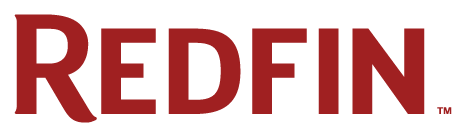

In [22]:
response.text

Create an object of the BeautifulSoup class to parse the web page text with the html.parser parser option

In [23]:
response_soup = BeautifulSoup(response.text, 'html.parser')

Print the BeautifulSoup object as a nicely (pretty) formatted string

<!DOCTYPE html5>
<head>
 <meta charset="utf-8"/>
 <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
 <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
 <meta content="width=device-width,initial-scale=1" name="viewport"/>
 <script src="https://www.google.com/recaptcha/api.js">
 </script>
 <style type="text/css">
  #submit {
        -webkit-border-radius: 4;
        -moz-border-radius: 4;
        border-radius: 4px;
        font-family: Arial;
        font-size: 16px;
        background: #0c82a5;
        padding: 7px 10px 7px 10px;
        text-decoration: none;
        color: #ffffff;
        border: none;
    }

    #submit:hover {
        background: #3cb0fd;
        text-decoration: none;
    }

    body {
        font-family: Arial,"Helvetica Neue",Helvetica,sans-serif;
        margin: 0;
    }
    div#header {
        height: 59px;
        width: 100%;
        background-color: #fff;
        box-shadow: 0 0 1px rgba(0,0,0,.3);
    }

    div#error {
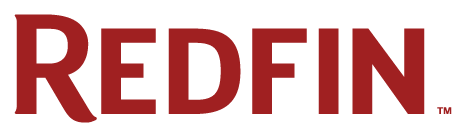

In [24]:
print(response_soup.prettify())

Open the URL in Chrome. Inspect the elements to find a pattern between the property listings.

Identify the tag, attribute, and attribute value for the outermost portion of each listing.

Do a findAll to assign a list of properties to a variable.

In [102]:
# <div class="HomeCardContainer selectedHomeCard" id="MapHomeCard_0" data-rf-test-id="react-data-photo-row-0">
listings = response_soup.findAll('div', attrs={'class': 'HomeCardContainer'})
type(listings)

bs4.element.ResultSet

Print out the variable containing the list of jobs

In [103]:
for listing in listings:
    print(listing)
    print("-"*100)


- Create a dictionary to hold the property details. Initialize the dictionary values to an empty list for each key.

In [104]:
# dictionary keys

'''
address - includes address 1, address 2, city, state, zip
bedroom_count - num of bedrooms
bathroom_count - num of bathrooms
price - price of listing
square_ft - size of property in ft^2
link - web url to individual listing
'''

property_listing_dict = {
    'address': [],
    'price': [],
    'square_ft': [],
    'bedroom_count': [],
    'bathroom_count': [],
    'link': []
}

- Loop through the listings
    - Scrape for the required listing components and assign each to a variable
    - Append the variable to the appropriate key for the dictionary initialized above
    - Print out the variable value
    - To delimit each article, print out a line of repeating non-alphanumeric characters of choice
    
Print out the contents of the property listing dictionary

In [105]:
for listing in listings:
    redfin_base_url = 'https://www.redfin.com'
    # to sort through listings, must remove 'fake' listing (redfin advertisements) from the loop
    listing_header = listing.find('div')['class'][0]
    # print(listing_header)
    if listing_header == 'MerchPlacement':
        listings.remove(listing)
        continue
    
    # address
    # <div class="addressDisplay font-size-smaller" data-rf-test-id="abp-homeinfo-homeaddress">
    # <span data-rf-test-id="abp-streetLine">8425 Lilienthal Ave, Los Angeles, CA 90045</span></div>
    address = listing.find('div', attrs={'class': 'addressDisplay font-size-smaller'}).text
    property_listing_dict['address'].append(address)
    print(address)
    
    # price
    # <div class="bottomV2 ">
    # <span class="homecardV2Price" data-rf-test-name="homecard-price">$899,000</span>
    price = listing.find('span', attrs={'class': 'homecardV2Price'}).text
    property_listing_dict['price'].append(price)
    print(price)
    
    # square_ft
    # <div class="HomeStatsV2 font-size-small">
    # <div class="stats">2 Beds</div>
    # <div class="stats">2 Baths</div>
    # <div class="stats">1,236 Sq. Ft.</div>
        # use .findAll to choose 3rd item of list
    square_ft = listing.findAll('div', attrs={'class': 'HomeStatsV2 font-size-small', 'class': 'stats'})[2].text
    property_listing_dict['square_ft'].append(square_ft)
    print(square_ft)
    
    # bedroom_count
    # <div class="HomeStatsV2 font-size-small">
    # <div class="stats">2 Beds</div>
    # <div class="stats">2 Baths</div>
    # <div class="stats">1,236 Sq. Ft.</div>
        # use .findAll to choose 1st item of list
    bedroom_count = listing.findAll('div', attrs={'class': 'HomeStatsV2 font-size-small', 'class': 'stats'})[0].text
    property_listing_dict['bedroom_count'].append(bedroom_count)
    print(bedroom_count)
    
    # bathroom_count
    # <div class="HomeStatsV2 font-size-small">
    # <div class="stats">2 Beds</div>
    # <div class="stats">2 Baths</div>
    # <div class="stats">1,236 Sq. Ft.</div>
        # use .findAll to choose 2nd item of list
    bathroom_count = listing.findAll('div', attrs={'class': 'HomeStatsV2 font-size-small', 'class': 'stats'})[1].text
    property_listing_dict['bathroom_count'].append(bathroom_count)
    print(bathroom_count)
    
    # link
    link = redfin_base_url + listing.find('a')['href']
    property_listing_dict['link'].append(link)
    print(link)
    
    print("-"*100)

Check to make sure dictionary is right length
- make sure dictionary doesn't have double entries caused by running the above cell multiple times

In [106]:
len(property_listing_dict['address'])

0

Assign the job details dictionary to a dataframe

In [5]:
df = pd.DataFrame(property_listing_dict)

KeyboardInterrupt: 

Print out the first 5 rows of the dataframe

In [108]:
df.head()

,address,price,square_ft,bedroom_count,bathroom_count,link


Establish a connection to sql-project database.

Append ?charset=utf8 to the database name to avoid codec errors.

In [109]:
try:
    connection = mysql.connector.connect(host='~AWS_HOST~',
                                         database='~DATABASE_NAME~',
                                         user='~USER~',
                                         password='~PASSWORD~',
                                         charset='utf8')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL Server version  8.0.20
You're connected to database:  ('sql_project',)
MySQL connection is closed


Insert the dataframe contents to the simplyhired_job table previously created.

Ensure your variables in the jobs for loop matches the table's column names. 

Set the if_exists argument to append to insert into the table already created.

Do not insert the dataframe's index column.
- For security reasons, AWS credentials have been replaced by \~ALL_CAPS\~.

In [110]:
engine = create_engine('mysql+mysqldb://~USER~:~PASSWORD~@~AWS_HOST~/~DATABASE_NAME~')
df.to_sql('redfin_properties_uncleaned', engine, index=False, if_exists='append')

### Clear out the redfin_properties_uncleaned table before proceeding. 
Run the following SQL in database client:

TRUNCATE TABLE redfin_properties_uncleaned;


### Make multiple requests for the Redfin search page to scrape prperty listings and save the results to the redfin_properties_uncleaned table
A single  search request only returns ~40 jobs."Paginate" through the results to gather all listings for a specific zipcode.

- For security reasons, AWS credentials have been replaced by \~ALL_CAPS\~.

In [111]:
ziplistTest = ['90713', '91306', '90002', '90506', '90069', '91361', '90064', '91308', '91702', '91104', '93535', '91345', '91803', '91791']
for zip in ziplistTest:
    
    url = "https://www.redfin.com/zipcode/" # add on zipcode suffix
    url += zip
    
    
    # ~MAKE_WEB_PAGE_REQUEST~
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"}
    request = requests.get(url, headers=headers)

    # ~CREATE_BEAUTIFULSOUP_OBJECT_TO_PARSE_WEB_PAGE~
    request_soup = BeautifulSoup(request.text, 'html.parser')

    # ~FIND_ALL_JOBS_AND_ASSIGN_TO_A_VARIABLE~
    listings = request_soup.findAll('div', attrs={'class': 'HomeCardContainer'})
    
    # find the total number of pages per zip code entry
    # since some zip codes have no listings, place in try-except block 
    try:
        total_pages = int(request_soup.find('span', attrs={'class': 'pageText'}).text[-1])
    except AttributeError:
        continue    
    # print(total_pages)
    
    # loop through each page of zip code listings
    for page in range(1, total_pages + 1):
        page_url_suffix = '/page-' + str(page)
        print('Page:', page)
        
        # once on to the next page after page 1, add new page number suffix to url
        # redo GET request on new url, prettify html, and organize into listings
        next_page_url = ''
        if page > 1:
            next_page_url = url + page_url_suffix
            headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"}
            request = requests.get(next_page_url, headers=headers)
            request_soup = BeautifulSoup(request.text, 'html.parser')
            listings = request_soup.findAll('div', attrs={'class': 'HomeCardContainer'})
            

        
        # ~INITIALIZE_DICTIONARY_TO_STORE_JOB_DETAILS~
        property_listing_dict = {
        'address': [],
        'price': [],
        'square_ft': [],
        'bedroom_count': [],
        'bathroom_count': [],
        'link': []
        }

        # ~LOOP_THROUGH_JOBS~
        for listing in listings:
            redfin_base_url = 'https://www.redfin.com'
            # to sort through listings, must remove 'fake' listing (redfin advertisements) from the loop
            listing_header = listing.find('div')['class'][0]
            # print(listing_header)
            if listing_header == 'MerchPlacement':
                listings.remove(listing)
                continue

            # ADDRESS
            address = listing.find('div', attrs={'class': 'addressDisplay font-size-smaller'}).text
            property_listing_dict['address'].append(address)
            print(address)

            # PRICE
            price = listing.find('span', attrs={'class': 'homecardV2Price'}).text
            property_listing_dict['price'].append(price)
            print(price)

            # SQUARE_FT
            square_ft = listing.findAll('div', attrs={'class': 'HomeStatsV2 font-size-small', 'class': 'stats'})[2].text
            property_listing_dict['square_ft'].append(square_ft)
            print(square_ft)

            # BEDROOM_COUNT
            bedroom_count = listing.findAll('div', attrs={'class': 'HomeStatsV2 font-size-small', 'class': 'stats'})[0].text
            property_listing_dict['bedroom_count'].append(bedroom_count)
            print(bedroom_count)

            # BATHROOM_COUNT
            bathroom_count = listing.findAll('div', attrs={'class': 'HomeStatsV2 font-size-small', 'class': 'stats'})[1].text
            property_listing_dict['bathroom_count'].append(bathroom_count)
            print(bathroom_count)

            # LINK
            link = redfin_base_url + listing.find('a')['href']
            property_listing_dict['link'].append(link)
            print(link)

            print("-"*100)
    
        # pause between website requests to not overload redfin network, or (most likely) get blocked
        time.sleep(.5)
        
# ~ASSIGN_JOBS_DICTIONARY_TO_A_DATAFRAME~
df = pd.DataFrame(property_listing_dict)
    
# ~INSERT_DATAFRAME_INTO_simplyhired_job_TABLE_WITH_if_exists_append_OPTION~
engine = create_engine('mysql+mysqldb://~USER~:~PASSWORD~@~AWS_HOST~/~DATABASE_NAME~')
df.to_sql('redfin_properties_uncleaned', engine, index=False, if_exists='append')